In [2]:
import kwant
from types import SimpleNamespace
from wraparound import wraparound
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
print(kwant.__version__)

plt.rcParams['text.usetex'] = True

/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/kwant/solvers/default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


1.4.1


In [7]:
import kwant.continuum
import scipy

template = kwant.continuum.discretize('k_x * A(x) * k_x')
print(template)

# Discrete coordinates: x

# Onsite element:
def onsite(site, A):
    (x, ) = site.pos
    _const_0 = (A(0.5 + x))
    _const_1 = (A(-0.5 + x))
    return (1.0*_const_0 + 1.0*_const_1)

# Hopping from (1,):
def hopping_1(site1, site2, A):
    (x, ) = site1.pos
    _const_0 = (A(0.5 + x))
    return (-1.0*_const_0)

# Discrete coordinates: x

# Onsite element:
def onsite(site, A):
    (x, ) = site.pos
    _const_0 = (A(-0.5 + x))
    _const_1 = (A(0.5 + x))
    return (1.0*_const_0 + 1.0*_const_1)

# Hopping from (1,):
def hopping_1(site1, site2, A):
    (x, ) = site1.pos
    _const_0 = (A(0.5 + x))
    return (-1.0*_const_0)


In [8]:
hamiltonian = "k_x**2 + k_y**2 + V(x, y)"
template = kwant.continuum.discretize(hamiltonian)
print(template)

# Discrete coordinates: x y

# Onsite element:
def onsite(site, V):
    (x, y, ) = site.pos
    _const_0 = (V(x, y))
    return (_const_0 + 4.0)

# Hopping from (1, 0):
(-1+0j)

# Hopping from (0, 1):
(-1+0j)


In [9]:
def stadium(site):
    (x, y) = site.pos
    x = max(abs(x) - 20, 0)
    return x**2 + y**2 < 30**2

syst = kwant.Builder()
syst.fill(template, stadium, (0, 0));
syst = syst.finalized()

In [10]:
def plot_eigenstate(syst, n=2, Vx=.0003, Vy=.0005):
  def potential(x, y):
    return Vx * x + Vy * y
  ham = syst.hamiltonian_submatrix(params=dict(V=potential), sparse=True)
  evecs = scipy.sparse.linalg.eigsh(ham, k=10, which='SM')[1]
  kwant.plotter.map(syst, abs(evecs[:, n])**2, show=False)

/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: The plotted data contains 1.13% of values overflowing upper limit 0.00115214 
  


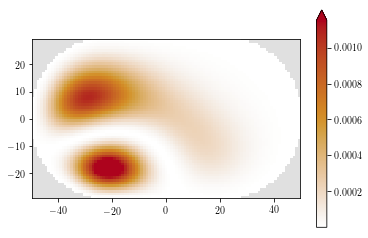

In [11]:
plot_eigenstate(syst)

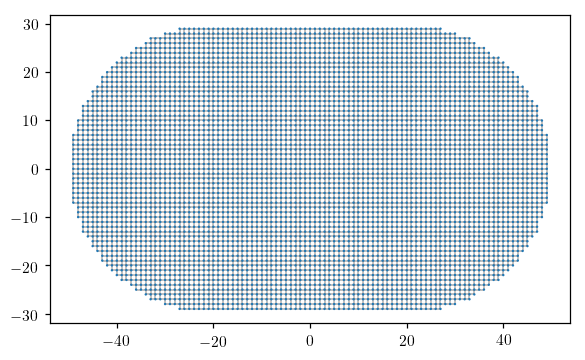

In [12]:
kwant.plot(syst, dpi=112);

Hamiltonian to implement:
$$
\mathcal H(\mathbf k) = \left(
    \begin{array}{cc}
      h(\mathbf k) & 0 \\
      0 & h^{\dagger}(-\mathbf k) 
    \end{array}
\right)
$$
$$
h(\mathbf k) = \epsilon(k) + \mathbf d (\mathbf k)\mathbf\sigma \textrm{, } \, \mathbf k = (k_x, k_y)
$$
$$
\mathbf d(\mathbf k ) = (Ak_x, Ak_y, M-Bk^2) \textrm{; } \, \epsilon(k) = C-Dk^2
$$

$$
= \left(
    \begin{array}{cc}
        (C-Dk^2)\sigma_0 + Ak_x\sigma_x + Ak_y\sigma_y + (M-Bk^2)\sigma_z & 0 \\
        0 & (C-Dk^2)\sigma_0 - Ak_x\sigma_x - Ak_y\sigma_y + (M-Bk^2)\sigma_z
    \end{array}
    \right)
$$


$$
=(C-Dk^2)\left(
\begin{array}{cc}
\sigma_0 & 0 \\
0 & \sigma_0
\end{array}
\right)
+ (M-Bk^2)
\left(
\begin{array}{cc}
\sigma_z & 0 \\
0 & \sigma_z
\end{array}
\right)
+ Ak_x 
\left(
\begin{array}{cc}
\sigma_x & 0 \\
0 & -\sigma_x
\end{array}
\right)
+ Ak_y
\left(
\begin{array}{cc}
\sigma_y & 0 \\
0 & -\sigma_y
\end{array}
\right)
$$

# Define the continuous hamiltonian

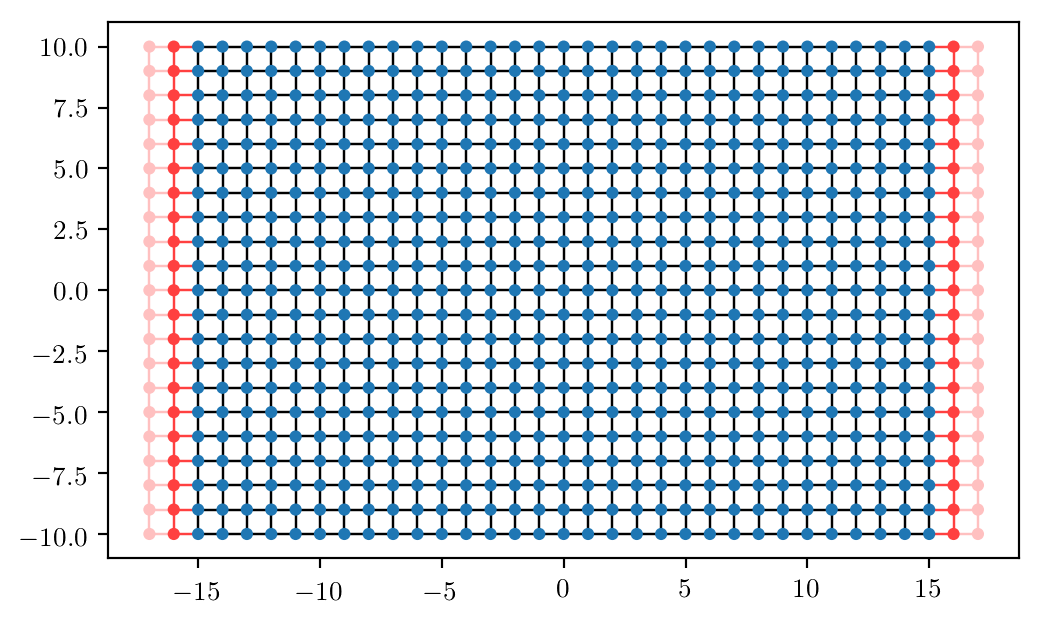

In [64]:
hamiltonian = """
(C-D*(k_x**2+k_y**2))*identity(4)
+ (M-B*(k_x**2+k_y**2))*kron(sigma_0, sigma_z)
+ A*k_x*kron(sigma_z, sigma_x)
+ A*k_y*kron(sigma_z, sigma_y)
+ W*identity(4)
"""

# Discretize hamiltonian
discrete_hamiltonian = kwant.continuum.discretize(hamiltonian)

# Define the system
W=20
L=30

def rectangle(site):
  (x, y) = site.pos
  return abs(x)<=L/2 and abs(y)<=W/2

syst = kwant.Builder()
syst.fill(discrete_hamiltonian, rectangle, (0, 0))

a = 1
t = -1
lat = kwant.lattice.square(a=a)
lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
lead.fill(discrete_hamiltonian, rectangle, (0, 0))

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())
fig=kwant.plot(syst, dpi=196);

In [65]:
fsyst=syst.finalized()

W0s = np.linspace(0, 10, 10) #np.logspace(0, np.log(5000)/np.log(10), 50)
energies = np.linspace(0, 0.6, 2)

# Parameters from article https://arxiv.org/abs/0905.4550v1
E_F = 7*1e-3 
M = -10*1e-3
A = 3.645
B = -68.8 
C = 0
D = -51.2

Gs = {}
for e in energies:
  Gs[repr(e)] = []
  for W0 in W0s:
      params = dict(A=A, B=B, C=C, D=D, M=M, W=np.random.uniform(-W0/2, W0/2))
      smat = kwant.smatrix(fsyst, energy=10*E_F, params=params)
      Gs[repr(e)].append(smat.transmission(1, 0))

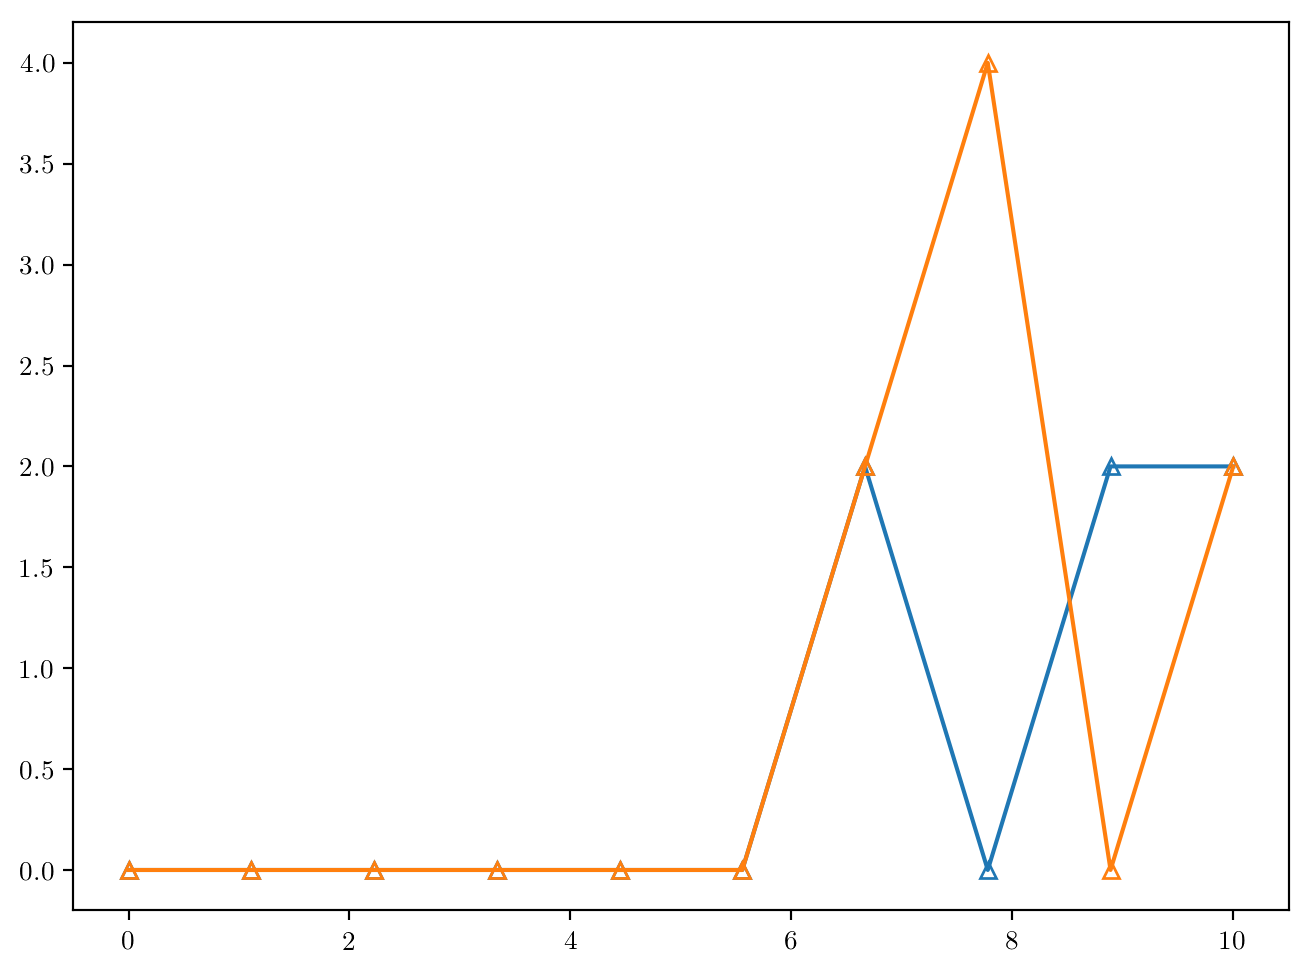

In [66]:
plt.figure(figsize=(8,6), dpi=196)
for e in energies:
  plt.plot(W0s, Gs[repr(e)], '^-', mfc='none', label="$E={}$".format(np.round(e, 2)));

# Plot spin densities